In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
#Install pix2pix incase if you have not yet downloaded
!pip install -q git+https://github.com/tensorflow/examples.git
#!pip install -q -U tfds-nightly

In [ ]:
## https://www.tensorflow.org/datasets/overview
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
import tensorflow_datasets as tfds
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [ ]:
#!pip install tensorflow_datasets

In [ ]:
#!pip install --user tensorflow_datasets

In [ ]:
import tensorflow_datasets as tfds
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [ ]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

### Download the Oxford-IIIT Pets dataset
* The dataset is already included in TensorFlow datasets, all that is needed to do is download it. The segmentation masks are included in version 3+.
* oxford_iiit_pet

In [ ]:
dataset,info = tfds.load('oxford_iiit_pet',with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJS6DHS/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJS6DHS/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
info.features

FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

In [ ]:
train_samples=info.splits['train'].num_examples
test_samples=info.splits['test'].num_examples

print(train_samples)
print(test_samples)

3680
3669


In [ ]:
dataset

{'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

In [ ]:
def normalize(input_image,input_mask):
    input_image =tf.cast(input_image,tf.float32) /255.0
    input_mask  = input_mask-1 # making the labels to 0,1,2 from 1,2,3
    return input_image,input_mask

In [ ]:
float(tf.random.uniform(()))

0.26182711124420166

In [ ]:
#https://www.tensorflow.org/guide/intro_to_graphs
#@tf.function
def load_image_train(datapoint):

    input_image = tf.image.resize(datapoint['image'],(128,128))
    input_mask  = tf.image.resize(datapoint['segmentation_mask'],(128,128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask  = tf.image.flip_left_right(input_mask)
    input_image,input_mask = normalize(input_image, input_mask)
    return input_image,input_mask


In [ ]:

def load_image_test(datapoint):
    
    input_image = tf.image.resize(datapoint['image'],(128,128))
    input_mask  = tf.image.resize(datapoint['segmentation_mask'],(128,128))
    input_image,input_mask = normalize(input_image, input_mask)
    return input_image,input_mask


In [ ]:
TRAIN_LENGTH =info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test  = dataset['test'].map(load_image_test)

In [ ]:
#https://www.tensorflow.org/guide/data_performance
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_dataset  = test.batch(BATCH_SIZE)


In [ ]:
def display( display_list):
    plt.figure(figsize=(15,15))

    title = ['Input Image',"True Mask","Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1,len(display_list),i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

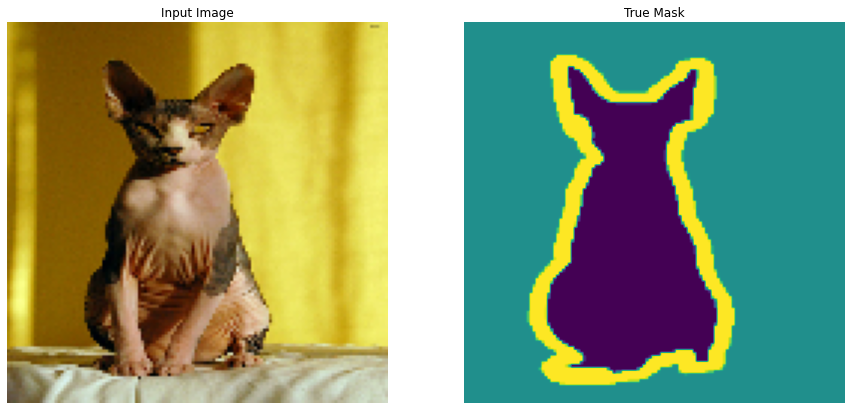

In [ ]:
for image , mask in train.take(5):
    sample_image,sample_mask = image,mask
display([sample_image,sample_mask])

## Define the model
* The model being used here is a modified U-Net. 
    * A U-Net consists of an encoder (downsampler) and decoder (upsampler). 
    * In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, 
    * The encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used.
    * The decoder will be the upsample block already implemented in TensorFlow Examples in the Pix2pix tutorial.

In [ ]:
OUTPUT_CHANNELS = 3

### Define Encoder -Downsampling

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project'      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


### Define Decoder - Upsampling

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [ ]:
### Combine Encoder and Decoder- Unet
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

      # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

      # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

      # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(output_channels,3, strides=2,padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Train the model

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

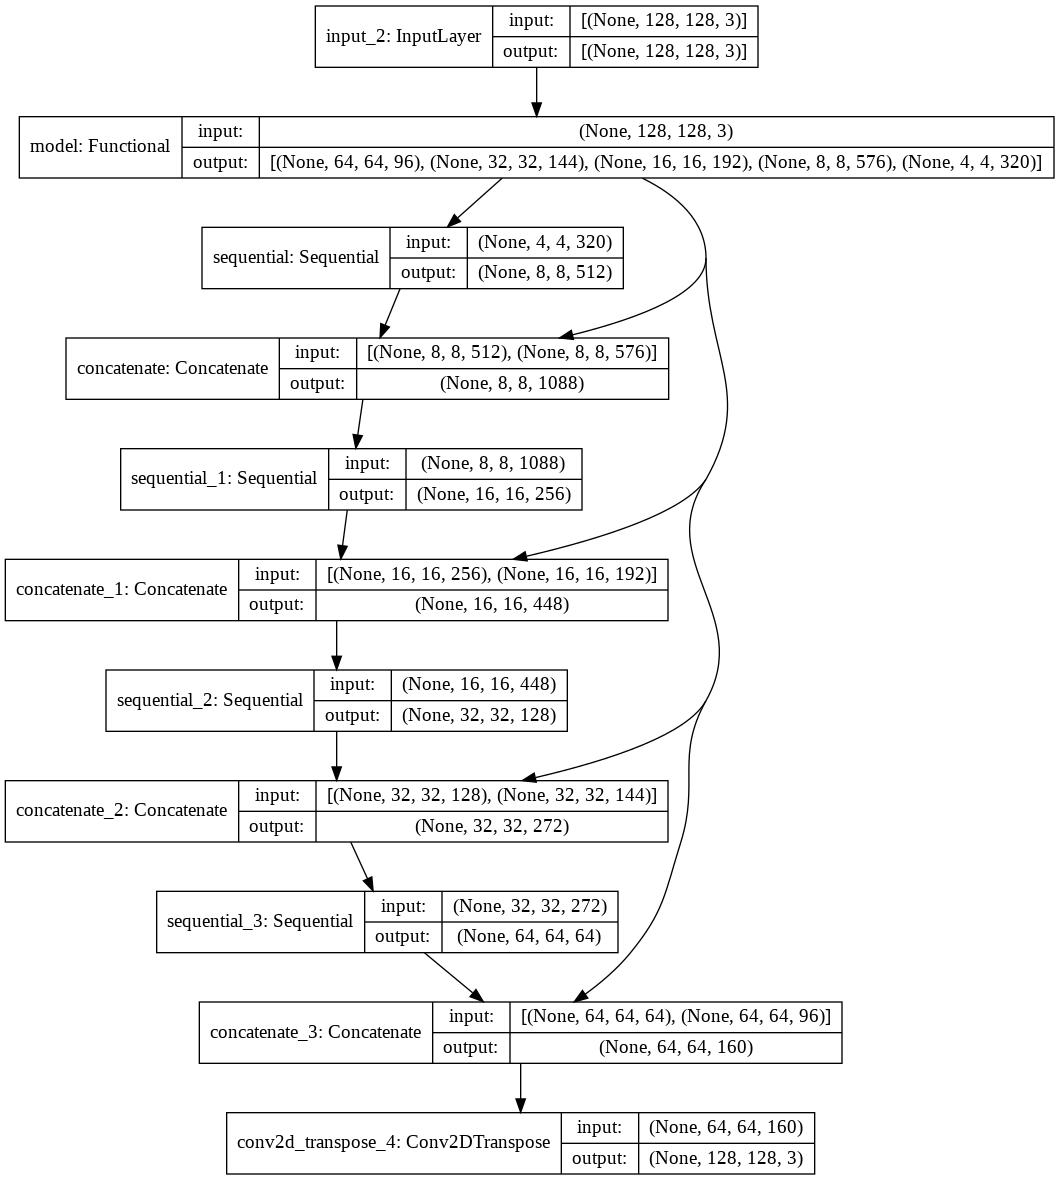

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) ### Get the class lable based on the probability
    pred_mask = pred_mask[..., tf.newaxis] ### create in image with additional dimension
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])



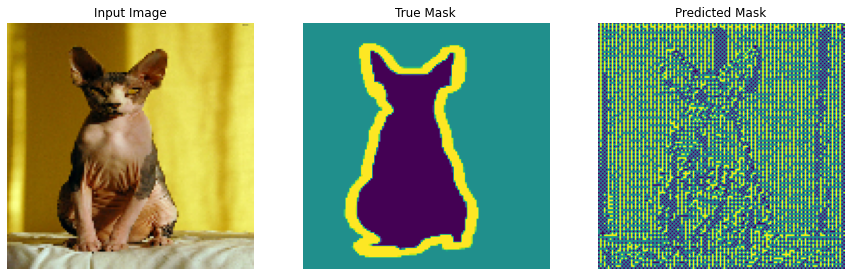

In [ ]:
show_predictions()

In [ ]:
# To understand create_mask
for image, mask in train_dataset.take(1): # A batch of images
  pred_mask = model.predict(image)

print(pred_mask.shape)
mask = create_mask(pred_mask)
print(mask.shape)
pred_mask1 = tf.argmax(pred_mask, axis=-1) ### Get the class lable based on the probability
print(pred_mask1.shape)
pred_mask2 = pred_mask1[..., tf.newaxis]
print(pred_mask2.shape)

(64, 128, 128, 3)
(128, 128, 1)
(64, 128, 128)
(64, 128, 128, 1)


In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

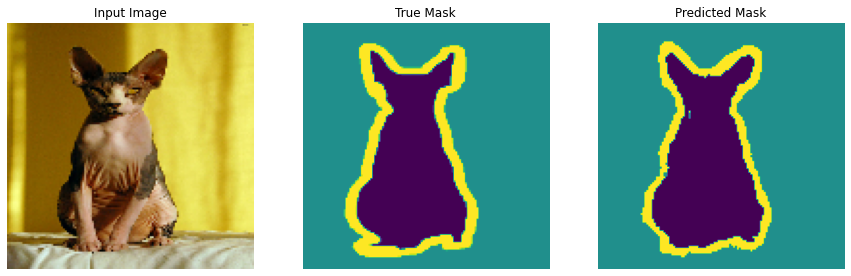


Sample Prediction after epoch 20



In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])


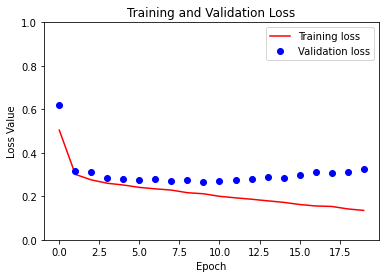

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

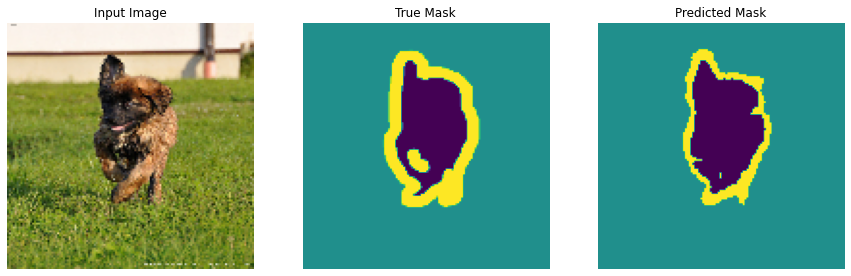

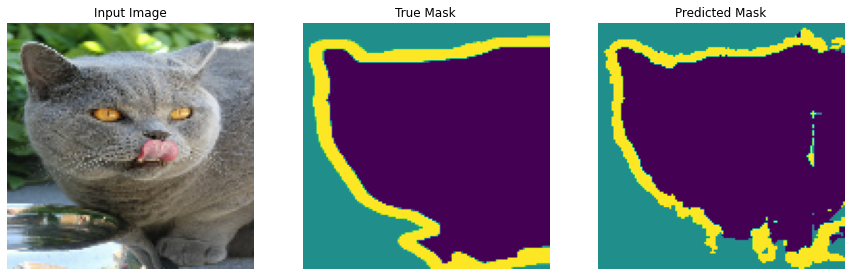

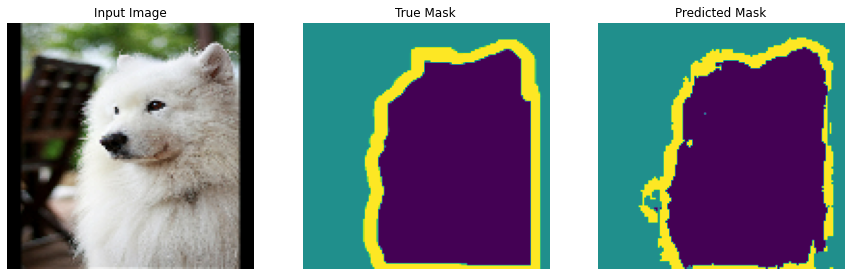

In [ ]:
show_predictions(test_dataset, 3)